In [ ]:
from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
raw_folder = "/content/drive/MyDrive/GraduationThesis_CN_DC/Rice-Leaf-Diseases-Dataset/"

594
1142
776
1488
1000
Total Dataset: 5000


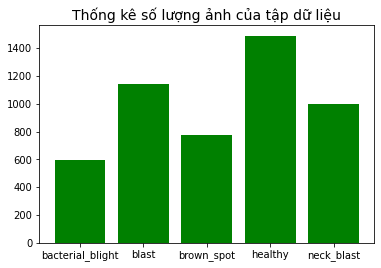

In [ ]:
#Thong ke so luong hinh anh
import time
import os
from os.path import exists
import pandas as pd
def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return counter

number_data1 = count('/content/drive/MyDrive/GraduationThesis_CN_DC/Rice-Leaf-Diseases-Dataset/bacterial_blight')
number_data2 = count('/content/drive/MyDrive/GraduationThesis_CN_DC/Rice-Leaf-Diseases-Dataset/blast')
number_data3 = count('/content/drive/MyDrive/GraduationThesis_CN_DC/Rice-Leaf-Diseases-Dataset/brown_spot')
number_data4 = count('/content/drive/MyDrive/GraduationThesis_CN_DC/Rice-Leaf-Diseases-Dataset/healthy')
number_data5 = count('/content/drive/MyDrive/GraduationThesis_CN_DC/Rice-Leaf-Diseases-Dataset/neck_blast')


print(number_data1)
print(number_data2)
print(number_data3)
print(number_data4)
print(number_data5)
print("Total Dataset:", number_data1+number_data2+number_data3+number_data4+number_data5)
x = ['bacterial_blight', 'blast', 'brown_spot', 'healthy', 'neck_blast']
y = [number_data1, number_data2, number_data3, number_data4, number_data5]
Data = {'Dataset': x,
        'Data': y}
df = pd.DataFrame(Data,columns=['Dataset','Data'])

New_Colors = ['green','green','green', 'green', 'green']
plt.bar(df['Dataset'], df['Data'], color=New_Colors, width = 0.8)
plt.title('Thống kê số lượng ảnh của tập dữ liệu', fontsize=14)
plt.show()

In [ ]:
def save_data(raw_folder=raw_folder):
  dest_size = (224, 2244)
  print("Preprocessing Image...")

  pixels = []
  labels= []

  # Lap qua cac folder con trong thu muc raw
  for folder in listdir(raw_folder):
    if folder != '.DS_Store':
      print("Folder =", folder)
      # Lap qua cac file trong tung thu muc chua cac anh
      for file in listdir(raw_folder + folder):
        if file != '.DS_Store':
          print("File =", file)
          pixels.append(cv2.resize(cv2.imread(raw_folder  + folder +"/" + file),dsize=(224,224)))
          labels.append(folder)

  pixels = np.array(pixels)
  labels = np.array(labels)#.reshape(-1,1)

  from sklearn.preprocessing import LabelBinarizer
  encoder = LabelBinarizer()
  labels = encoder.fit_transform(labels)
  print(labels)

  file = open('/content/drive/MyDrive/GraduationThesis_CN_DC/Lab/VGG_16/pix.data', 'wb')
  # dump information to that file
  pickle.dump((pixels,labels), file)
  # close the file
  file.close()

  return


In [ ]:
def load_data():
    file = open('/content/drive/MyDrive/GraduationThesis_CN_DC/Lab/VGG_16/pix.data', 'rb')

    # load cac du lieu hinh anh va nhan
    (pixels, labels) = pickle.load(file)

    # giai phong tap tin
    file.close()

    print(pixels.shape)
    print(labels.shape)

    return pixels, labels

In [ ]:
#Luu du lieu vao file pix.data
save_data()

In [ ]:
#Load du lieu
X, y = load_data()

(5000, 224, 224, 3)
(5000, 5)


In [ ]:
print(X)
print(y)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
print(len(X_train_val))
print(len(X_test))
print(len(y_train_val))
print(len(y_test))

4500
500
4500
500


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=100)
print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

4050
450
4050
450


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=100)

In [ ]:
print(y_train)

[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 1 0 0 0]
 ...
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]]


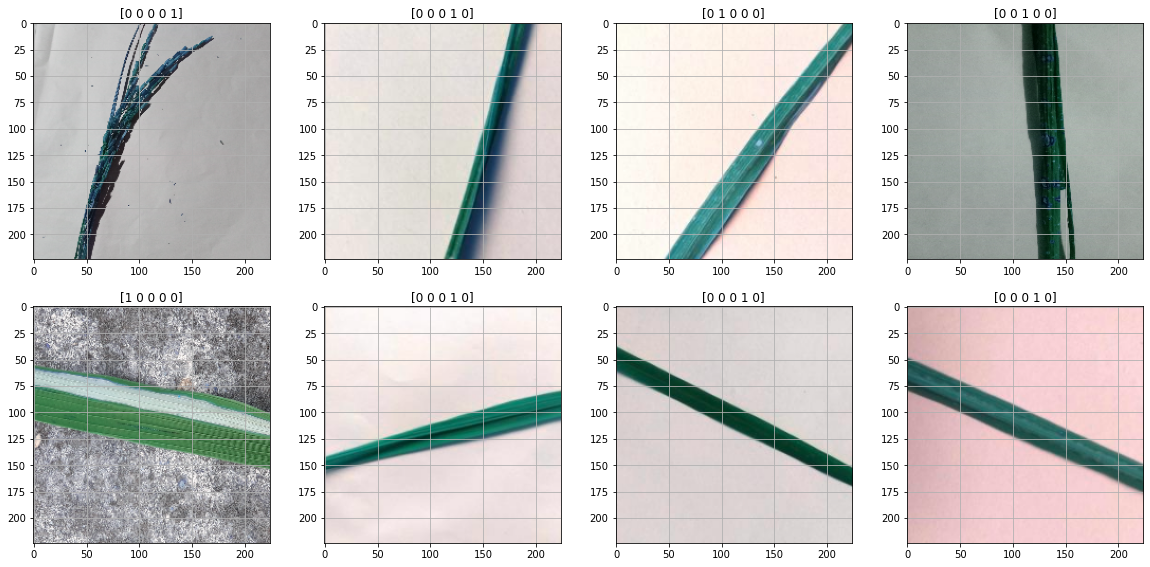

In [ ]:
import numpy as np
import pandas as pd

plt.figure(figsize=(20, 20))

for i in range(8):  
  plt.subplot(4, 4, i+1)
  #In nhãn (class)
  plt.title(([y_train[i]][0]))
  plt.xticks()
  plt.yticks()
  plt.grid(True)
  #In hình
  plt.imshow(X_train[i])

plt.show()

In [ ]:
print((X_train.shape,y_train.shape))
print((X_val.shape,y_val.shape))
print((X_test.shape,y_test.shape))

((4050, 224, 224, 3), (4050, 5))
((450, 224, 224, 3), (450, 5))
((500, 224, 224, 3), (500, 5))


In [ ]:
from keras.applications.vgg16 import VGG16


def get_model():
    # Khoi tao base model
    base_model_vgg16 = VGG16(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )
    
    # Khoi tao model chính
    x = base_model_vgg16.output
    # Them cac lop FC
    x = GlobalMaxPooling2D()(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    outs = Dense(5, activation='softmax', name='predictions')(x)

    # Dong bang cac Layer
    for layer in base_model_vgg16.layers:
        layer.trainable = False

    model = Model(inputs=base_model_vgg16.inputs, outputs= outs)
    # Compile
    model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model

vgg16_model = get_model()

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
filepath="/content/drive/MyDrive/GraduationThesis_CN_DC/Lab/Lab-Test/VGG16/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
aug = ImageDataGenerator(
  featurewise_center=False, # Dat gia tri dau vao thanh 0 tren tap du lieu
  samplewise_center=False, #  Dat gia tri trung binh cua moi mau thanh 0
  featurewise_std_normalization=False, #  Chia dau vao cho std cua tap du lieu
  samplewise_std_normalization=False,  #  Chia moi dau vao cho std cua no
  zca_whitening=False,  # apply ZCA whitening
  rotation_range=10,  # xoay hinh anh ngau nhien trong pham vi (do, 0 den 180) 
  zoom_range = 0.2, # Hinh anh thu phong ngau nhien
  width_shift_range=0.1,  # dich chuyen ngau nhien hinh anh theo chieu ngang
  height_shift_range=0.1,  # dich chuyen ngau nhien hinh anh theo chieu doc
  horizontal_flip=True,  # hinh anh lat ngau nhien 
  vertical_flip=False, # hinh anh lat ngau nhien
  brightness_range=[0.2, 1.5] # dieu chinh do sang
)

In [ ]:
history=vgg16_model.fit_generator(
    aug.flow(X_train, y_train, batch_size=32),
    epochs=200,
    steps_per_epoch=len(X_train)//32,
    validation_data=aug.flow(X_val,y_val, batch_size=32),
    validation_steps=len(X_test)//32
)

In [ ]:
loss, acc = vgg16_model.evaluate(X_test, y_test)
print("Accuracy:", acc)
print("Loss:", loss)

16/16 [==============================] - 5s 300ms/step - loss: 0.6044 - accuracy: 0.8440
Accuracy: 0.843999981880188
Loss: 0.6044461131095886


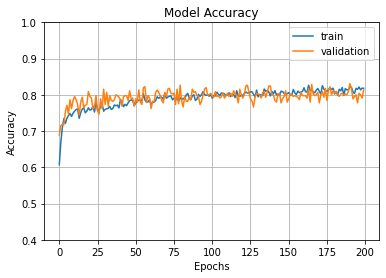

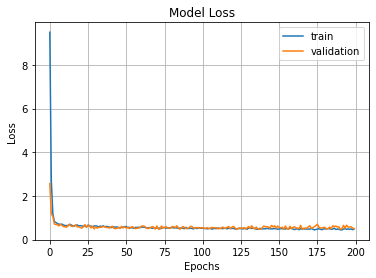

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
#Defining function for confusion matrix plot
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, fontsize=10, ha='right')
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

import tensorflow as tf
#Making prediction
y_pred = np.argmax(vgg16_v3_model.predict(X_test), axis=-1)
y_true = np.argmax(y_test,axis=1)
#Plotting the confusion matrix
confusion_matrix(y_true, y_pred)

Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.91      0.89      0.90        66
           1       0.76      0.74      0.75       117
           2       0.82      0.65      0.73        81
           3       0.79      0.90      0.84       132
           4       0.98      1.00      0.99       104

    accuracy                           0.84       500
   macro avg       0.85      0.84      0.84       500
weighted avg       0.84      0.84      0.84       500



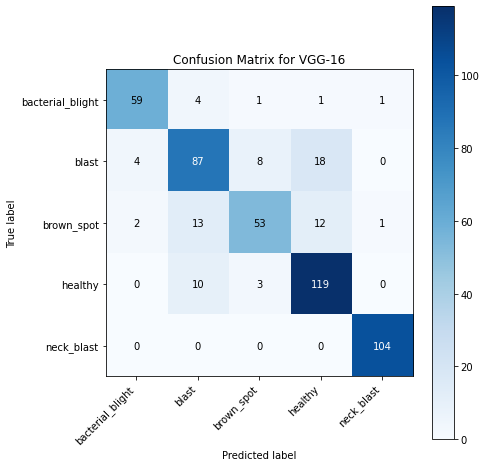

In [ ]:
class_names = ['bacterial_blight', 'blast', 'brown_spot', 'healthy', 'neck_blast']
plot_confusion_matrix(y_true, y_pred, classes = class_names,  title = 'Confusion Matrix for VGG-16')
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred, digits = 2))

In [ ]:
vgg16_model.save("/content/drive/MyDrive/GraduationThesis_CN_DC/Model/Transfer_Learning_VGG16_Version03.h5")

In [ ]:
from tensorflow.keras.models import load_model
vgg16_v4_model = load_model('/content/drive/MyDrive/GraduationThesis_CN_DC/Model/Transfer_Learning_VGG16_Version04.h5')

In [ ]:
vgg_history=vgg16_v4_model.fit_generator(
    aug.flow(X_train, y_train, batch_size=32),
    epochs=50,
    steps_per_epoch=len(X_train)//32,
    validation_data=aug.flow(X_val,y_val, batch_size=32),
    validation_steps=len(X_test)//32
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
126/126 [==============================] - 70s 471ms/step - loss: 0.4537 - accuracy: 0.8253 - val_loss: 0.7252 - val_accuracy: 0.7933
Epoch 2/50
126/126 [==============================] - 57s 449ms/step - loss: 0.4898 - accuracy: 0.8213 - val_loss: 0.5591 - val_accuracy: 0.8000
Epoch 3/50
126/126 [==============================] - 58s 460ms/step - loss: 0.4569 - accuracy: 0.8230 - val_loss: 0.8121 - val_accuracy: 0.7867
Epoch 4/50
126/126 [==============================] - 57s 450ms/step - loss: 0.4638 - accuracy: 0.8216 - val_loss: 0.5835 - val_accuracy: 0.8311
Epoch 5/50
126/126 [==============================] - 56s 445ms/step - loss: 0.4583 - accuracy: 0.8211 - val_loss: 0.5634 - val_accuracy: 0.8000
Epoch 6/50
126/126 [==============================] - 58s 459ms/step - loss: 0.4397 - accuracy: 0.8280 - val_loss: 0.5199 - val_accuracy: 0.8133
Epoch 7/50
126/126 [==============================] - 57s 448ms/step - loss: 0.4691 - accuracy: 0.8216 - val_loss: 0.5094 - val_ac

In [ ]:
loss, acc = vgg16_v4_model.evaluate(X_test, y_test)
print("Accuracy:", acc)
print("Loss:", loss)

16/16 [==============================] - 5s 290ms/step - loss: 0.6960 - accuracy: 0.8360
Accuracy: 0.8360000252723694
Loss: 0.6959623098373413


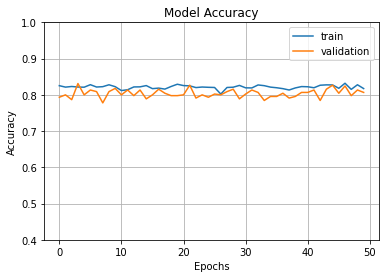

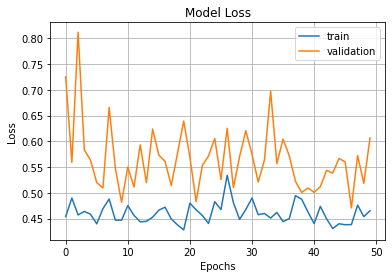

In [ ]:
fig1 = plt.gcf()
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
#Defining function for confusion matrix plot
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Computing confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

# Visualizing
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

   # Rotating the tick labels and setting their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, fontsize=10, ha='right')
    # Looping over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

import tensorflow as tf
#Making prediction
y_pred = np.argmax(vgg16_v4_model.predict(X_test), axis=-1)
y_true = np.argmax(y_test,axis=1)
#Plotting the confusion matrix
confusion_matrix(y_true, y_pred)

16/16 [==============================] - 2s 156ms/step


array([[ 60,   3,   2,   0,   1],
       [  8,  73,  10,  26,   0],
       [  3,   9,  56,  13,   0],
       [  0,   7,   0, 125,   0],
       [  0,   0,   0,   0, 104]])

Confusion matrix, without normalization
                  precision    recall  f1-score   support

bacterial_blight       0.85      0.91      0.88        66
           blast       0.79      0.62      0.70       117
      brown_spot       0.82      0.69      0.75        81
         healthy       0.76      0.95      0.84       132
      neck_blast       0.99      1.00      1.00       104

        accuracy                           0.84       500
       macro avg       0.84      0.83      0.83       500
    weighted avg       0.84      0.84      0.83       500



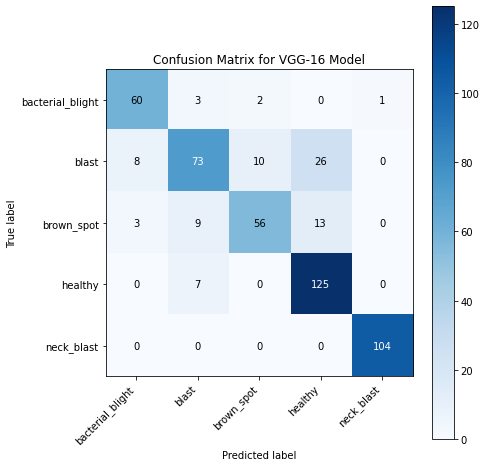

In [ ]:
class_names = ['bacterial_blight', 'blast', 'brown_spot', 'healthy', 'neck_blast']
plot_confusion_matrix(y_true, y_pred, classes = class_names,  title = 'Confusion Matrix for VGG-16 Model')
from sklearn import metrics
print(metrics.classification_report(y_true, y_pred, digits = 2, target_names=class_names))

(1, 224, 224, 3)
1/1 [==============================] - 1s 711ms/step


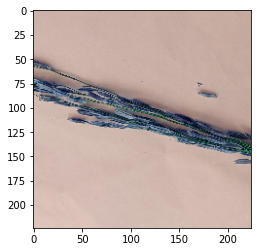

The predicted class is neck_blast


In [ ]:
import cv2
image_from_test_data = "/content/drive/MyDrive/GraduationThesis_CN_DC/Dataset/Dataset-Processing/test/neck_blast/neck_blast_103.jpg"
image=cv2.imread(image_from_test_data)
image_resized= cv2.resize(image, (224,224))
image=np.expand_dims(image_resized,axis=0)
print(image.shape)
class_names = ['bacterial_blight', 'blast', 'brown_spot', 'healthy', 'neck_blast']
pred=vgg16_v4_model.predict(image)
pred_digits=np.argmax(pred, axis=1)

plt.imshow(np.squeeze(image))
plt.show()

output_class=class_names[np.argmax(pred)]
print("The predicted class is", output_class)

In [ ]:
vgg16_v4_model.save("/content/drive/MyDrive/GraduationThesis_CN_DC/Model/Transfer_Learning_VGG16_Version05.h5")